In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'memotion_analysis/'

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/memotion_analysis/kaggle_dataset/meme_dataset.csv')
df['text_corrected'] = df['text_corrected'].astype(str)
df.reset_index()
df

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,look friend lightyear sohalikut trend play...,0.000000,0.000000,0.000000,0.0,0
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,best 10 yearchallenge completed less 4 kud...,0.333333,0.000000,0.000000,1.0,0
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,sam thorne follow follow saw everyone postin...,0.666667,0.333333,0.000000,0.0,0
3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 year challenge sweet dee edition,0.666667,0.666667,0.333333,1.0,0
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 year challenge filter 47 hilarious 10 yea...,0.000000,1.000000,0.333333,0.0,2
...,...,...,...,...,...,...,...,...
6983,image_6988.jpg,Tuesday is Mardi Gras Wednesday is Valentine's...,tuesday mardi gras wednesday valentine frida...,0.666667,0.666667,0.333333,1.0,2
6984,image_6989.jpg,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,must watch movies 2017 iti chennai memes maan...,1.000000,0.666667,0.000000,0.0,2
6985,image_6990.png,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,less talking planning soda junk food complain...,1.000000,0.000000,0.666667,0.0,0
6986,image_6991.jpg,When I VERY have time is a fantasy No one has ...,time one time unless make,0.333333,0.666667,0.000000,1.0,0


In [ ]:
%cd 'gdrive'
%cd 'My Drive'
%cd 'memotion_analysis'
%cd 'kaggle_dataset'
%cd 'images'
print('Number of memes:')
!ls -1 | wc -l


/content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/memotion_analysis
/content/gdrive/My Drive/memotion_analysis/kaggle_dataset
/content/gdrive/My Drive/memotion_analysis/kaggle_dataset/images
Number of memes:
6998


In [ ]:
print('Number of positive memes:', len(df[df['overall_sentiment'] == 0]))
print('Number of negative memes:', len(df[df['overall_sentiment'] == 1]))
print('Number of neutral memes:', len(df[df['overall_sentiment'] == 2]))

Number of positive memes: 4157
Number of negative memes: 631
Number of neutral memes: 2200


**Train and validation datasets**
We now create the train and validation datasets required for learning.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test = train_test_split(df, test_size=0.1)
test_df, dev_df = train_test_split(test, test_size=0.8)

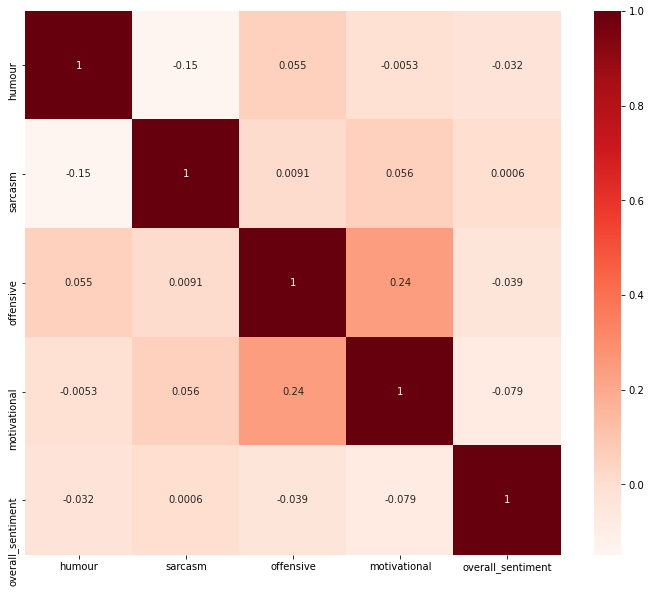

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12,10))
cor = train_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Charts above show importance of humour, motivational, offensive and sarcasm features for training a network to evaluate overall sentiments. We use humour and motivational features for training due to the dominance of their importance compared to other features.

In [ ]:
# Shuffle train dataframe
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df['overall_sentiment'].value_counts()

0    3747
2    1978
1     564
Name: overall_sentiment, dtype: int64

In [ ]:
train_df

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_2471.jpg,when you open the door of your son's bedroom a...,open door son bedroom staring pc des...,1.000000,0.333333,0.000000,0.0,0
1,image_4869.jpg,I GUESS YOU COULD SAY THAT I HAD LIVED MY LIFE...,guess could say lived life macs,0.666667,0.000000,0.666667,1.0,2
2,image_751.jpg,When Chuck Norris crosses the street the cars ...,chuck norris crosses street cars look,0.000000,0.000000,0.666667,0.0,0
3,image_2941.jpg,SWIMMING WITH THE JELLIES FRIGHTEOUS,swimming jellies frighteous righteous,1.000000,0.333333,0.000000,0.0,0
4,image_1492.jpg,when his point is valid and you just kinda sit...,point valid kinda sit like,0.666667,0.666667,0.666667,0.0,1
...,...,...,...,...,...,...,...,...
6284,image_4085.png,IS INSECURE AOUT BEING JUDGED AND GETS OFFENDE...,insecure aout judged gets offended people ...,0.000000,0.000000,0.333333,0.0,0
6285,image_2642.jpg,Stop waiting for Prince Charming. Get up and f...,stop waiting prince get find poor idiot m...,0.333333,0.000000,0.000000,0.0,2
6286,image_6196.jpg,CHUCK NORRIS ONCE BUILT A PRINTER IT HAS NEVER...,chuck norris built printer never,0.666667,0.333333,0.000000,0.0,0
6287,image_5302.jpg,I DON'T GET LUCKY. I MADE MY OWN LUCK. MILLION...,get made,0.000000,0.333333,0.000000,1.0,0


In [ ]:
# Shuffle validation dataframe
dev_df = dev_df.sample(frac=1).reset_index(drop=True)
dev_df['overall_sentiment'].value_counts()

0    326
2    181
1     53
Name: overall_sentiment, dtype: int64

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________

**Loading images**
Now we save images and other of features required for network learning into lists.

In [ ]:
from keras.preprocessing import image as keras_image


def preprocess_image(image):
  img = image.copy()
  img = keras_image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img//255.0

  return img

In [ ]:
train_list = train_df.to_dict('records')
validation_list = dev_df.to_dict('records')

In [ ]:
# Create train and validation dataset 
xs_images = {'train': [], 'validation': []}
xs_categoricals = {'train': [], 'validation': []}
xs_texts = {'train': [], 'validation': []}
ys = {'train': [], 'validation': []}

for image_data in train_list:
  try:
    image = keras_image.load_img(image_data['image_name'], target_size=(200, 200))
  except Exception as e:
    print(e)
    continue

  image = preprocess_image(image)
  features = base_model.predict(image)
  xs_images['train'].append(features)
  xs_texts['train'].append(image_data['text_corrected'])
  humour = image_data['humour']
  motivational = image_data['motivational']
  xs_categoricals['train'].append([humour, motivational])
  ys['train'] += [image_data['overall_sentiment']]

for image_data in validation_list:
  try:
    image = keras_image.load_img(image_data['image_name'], target_size=(200, 200))
  except Exception as e:
    print(e)
    continue
    
  image = preprocess_image(image)
  features = base_model.predict(image)
  xs_images['validation'].append(features)
  xs_texts['validation'].append(image_data['text_corrected'])
  humour = image_data['humour']
  motivational = image_data['motivational']
  xs_categoricals['validation'].append([humour, motivational])
  ys['validation'] += [image_data['overall_sentiment']]


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


image file is truncated


In [ ]:
xs_images['train'][3].shape

(1, 4, 4, 2048)

In [ ]:
# Sanity check
assert (len(ys['train']) == len(xs_images['train']) == len(xs_texts['train'])),"There is some problem."
assert (len(ys['validation']) == len(xs_images['validation']) == len(xs_texts['validation'])),"There is some problem."

In [ ]:
# for index, image_data in enumerate(train_list):
#   if type(image_data['text_corrected']) == float:
#     train_list[index] = str(image_data['text_corrected'])

# for index, image_data in enumerate(validation_list):
#   if type(image_data['text_corrected']) == float:
#     validation_list[index] = str(image_data['text_corrected'])

**Word2Vec Embedding** Now its time to embed texts using pre-trainded embedding model Word2Vec.

In [ ]:
# Find texts maximum length for padding
MAX_SEQUENCE_LENGTH = 0
for image_data in train_list:
  MAX_SEQUENCE_LENGTH = max(MAX_SEQUENCE_LENGTH, len(image_data['text_corrected'].split(' ')))
for image_data in validation_list:
  MAX_SEQUENCE_LENGTH = max(MAX_SEQUENCE_LENGTH, len(image_data['text_corrected'].split(' ')))

print('max length:', MAX_SEQUENCE_LENGTH)

max length: 180


In [ ]:
%cd '..'
!wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip glove.6B.zip
!cp -a 'glove.6B.300d.txt' 'word2vec/'

/content/gdrive/My Drive/memotion_analysis/kaggle_dataset
--2020-09-20 08:12:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-20 08:12:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-20 08:12:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (

In [ ]:
all_texts = xs_texts['train'] + xs_texts['validation']
all_texts = list(set(all_texts))

In [ ]:
# Tokenize input texts
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


MAX_NB_WORDS = 10000

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(all_texts)
train_sequences = tokenizer.texts_to_sequences(xs_texts['train'])
validation_sequences = tokenizer.texts_to_sequences(xs_texts['validation'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

xs_texts['train'] = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
ys['train'] = to_categorical(np.asarray(ys['train']))
print('Shape of train data tensor:', xs_texts['train'].shape)
print('Shape of train label tensor:', ys['train'].shape)

xs_texts['validation'] = pad_sequences(validation_sequences, maxlen=MAX_SEQUENCE_LENGTH)
ys['validation'] = to_categorical(np.asarray(ys['validation']))
print('Shape of validation train data tensor:', xs_texts['validation'].shape)
print('Shape of validation train label tensor:', ys['validation'].shape)

Found 11668 unique tokens.
Shape of train data tensor: (6288, 180)
Shape of train label tensor: (6288, 3)
Shape of validation train data tensor: (560, 180)
Shape of validation train label tensor: (560, 3)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [ ]:
%cd '..'

import os


embeddings_index = {}

f = open('word2vec/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

/content/gdrive/My Drive/memotion_analysis/kaggle_dataset
Found 0 word vectors.


In [ ]:
EMBEDDING_DIM = 300
     

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector



**Building up the model** Now we create our baseline network using keras functional APIs and pre-trained CNN using VGG16 model.

In [ ]:
# Convert train and test dataset to numpy arrays
train_x = [np.asarray(xs_texts['train']), np.asarray(xs_images['train'])]
validation_data = ([np.asarray(xs_texts['validation']), np.asarray(xs_images['validation'])], ys['validation'])

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, MaxPool2D, Flatten, concatenate
from keras.models import Model


embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = embedding_layer(sequence_input)
lstm = LSTM(1024, return_sequences=True)(embedded_sequences)
lstm = LSTM(1024, return_sequences=True)(lstm)
lstm = LSTM(1024)(lstm)
lstm = Dense(512, activation='relu')(lstm)
lstm = Dense(512, activation='relu')(lstm)
lstm = Dense(1024, activation='relu')(lstm)


image_input = Input(shape=(1, 4, 4, 2048))
y = Flatten()(image_input)
y = Dense(4096, activation='relu')(y)
y = Dense(4096, activation='relu')(y)
y = Dense(2048, activation='relu')(y)
y = Dense(2048, activation='relu')(y)
y = Dense(2048, activation='relu')(y)
y = Dense(1024, activation='relu')(y)
y = Dense(1024, activation='relu')(y)


merged = concatenate([y, lstm], axis=1)
x = Dense(512, activation='relu')(merged)
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(3, activation='softmax', name='final')(x)
model = Model(inputs=[sequence_input, image_input], outputs=[output])

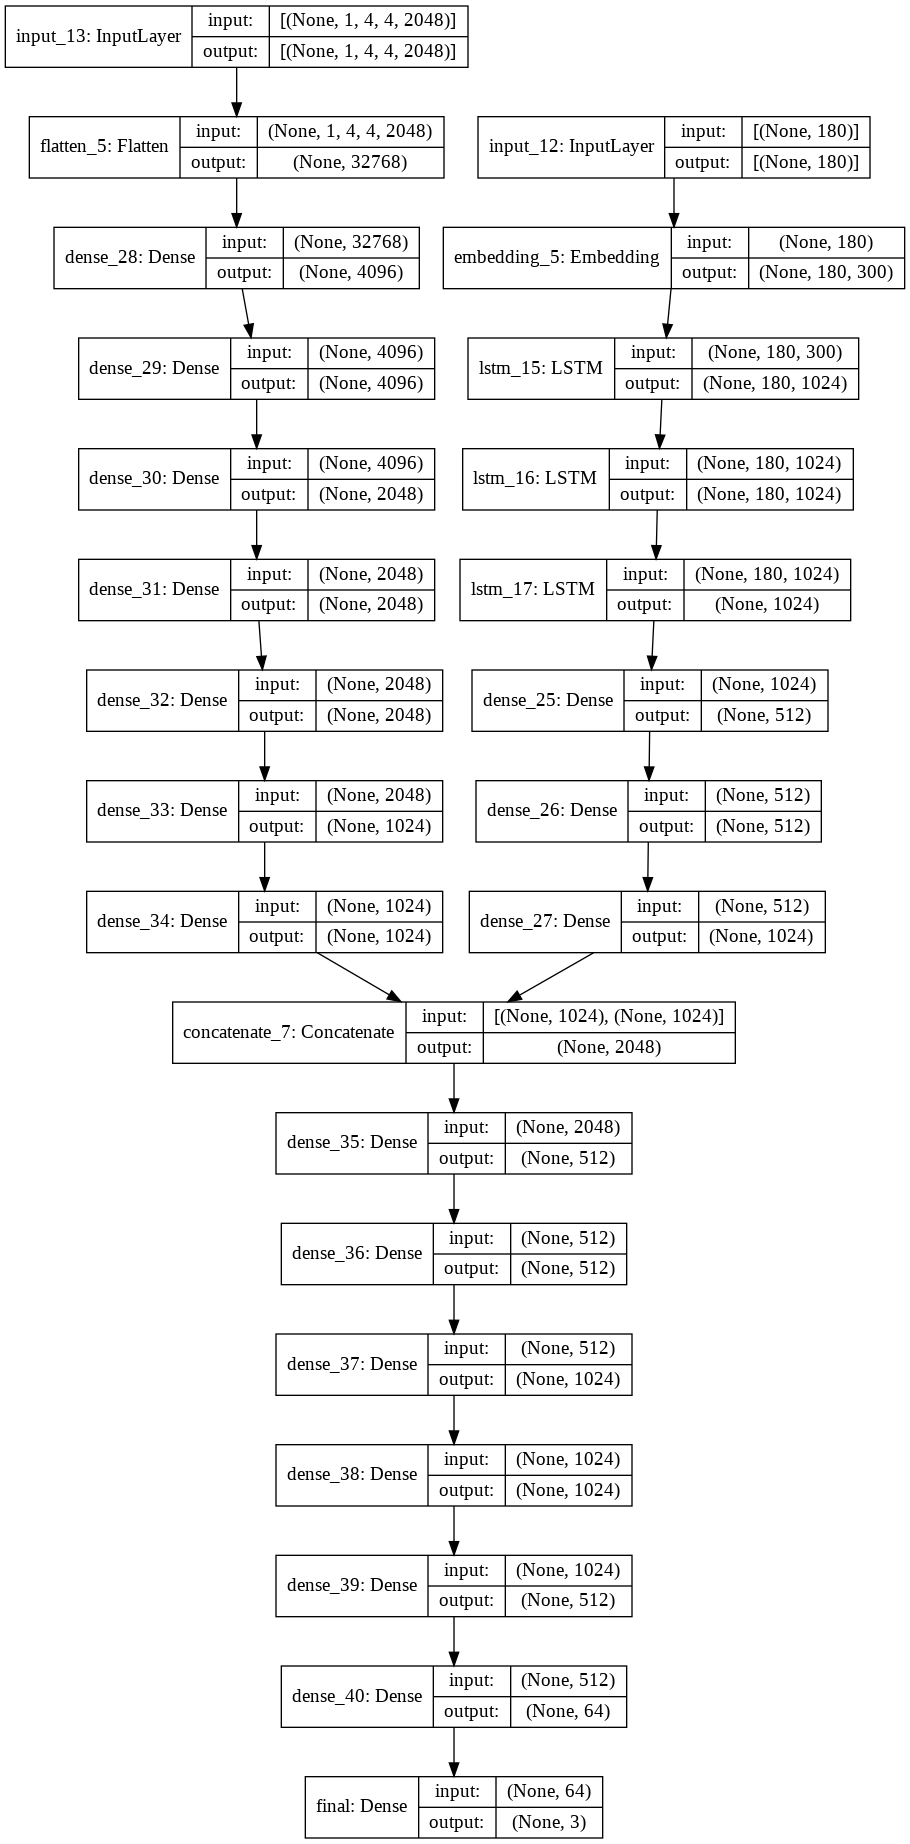

In [ ]:
from keras.utils import plot_model


plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# Create learning rate scheduler method in order to change lr during training session.
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def lr_scheduler(epoch, lr):
    if epoch % 30 == 0 and epoch != 0:
        lr = lr/10
        return lr
    return lr

In [ ]:
# Compute class weights in order to handle unbalanced data
from sklearn.utils.class_weight import compute_class_weight


y_integers = np.argmax(ys['train'], axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5648073295607653, 1: 3.664335664335664, 2: 1.0453865336658354}

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('gdrive/My Drive/memotion_analysis/saved_models/mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
lr_sch = LearningRateScheduler(lr_scheduler, verbose=1)

In [ ]:
from keras import optimizers


callbacks = [lr_sch, earlyStopping, mcp_save]
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_x, ys['train'], validation_data=validation_data, epochs=40, batch_size=64, class_weight=d_class_weights)

Epoch 1/40
99/99 [==============================] - 37s 340ms/step - loss: 1.0811 - accuracy: 0.3893 - val_loss: 1.0991 - val_accuracy: 0.0768
Epoch 2/40
99/99 [==============================] - 33s 330ms/step - loss: 1.0844 - accuracy: 0.1705 - val_loss: 1.0999 - val_accuracy: 0.0768
Epoch 3/40
99/99 [==============================] - 33s 330ms/step - loss: 1.1172 - accuracy: 0.0959 - val_loss: 1.0998 - val_accuracy: 0.0768
Epoch 4/40
99/99 [==============================] - 33s 330ms/step - loss: 1.0951 - accuracy: 0.2236 - val_loss: 1.0994 - val_accuracy: 0.0768
Epoch 5/40
99/99 [==============================] - 33s 330ms/step - loss: 1.0798 - accuracy: 0.4216 - val_loss: 1.0989 - val_accuracy: 0.0768
Epoch 6/40
99/99 [==============================] - 33s 330ms/step - loss: 1.1159 - accuracy: 0.0973 - val_loss: 1.0983 - val_accuracy: 0.6482
Epoch 7/40
99/99 [==============================] - 33s 330ms/step - loss: 1.1057 - accuracy: 0.3058 - val_loss: 1.0978 - val_accuracy: 0.2750

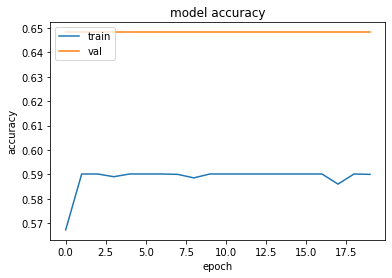

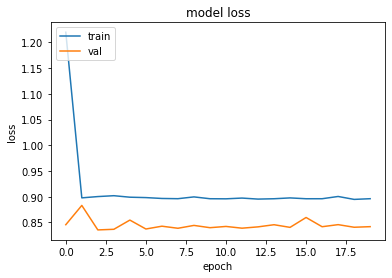

In [ ]:
import matplotlib.pyplot as plt


history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

ys_val = [np.where(r==1)[0][0] for r in validation_data[1]]
predictions = model.predict(validation_data[0])
print(classification_report(ys_val, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       363
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00       154

    accuracy                           0.65       560
   macro avg       0.22      0.33      0.26       560
weighted avg       0.42      0.65      0.51       560



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
